In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import copy
from IPython.core.display import Image
from lammps import lammps
from ClusterSim import input_classes

# Setup

In [175]:
lmp = lammps()
lmp.command("units          metal")
lmp.command("dimension      3")
lmp.command("atom_style     atomic")
lmp.command("atom_modify    map hash")
lmp.command("region         simbox block -30.0 30.0 -30.0 30.0 -30.0 30.0") # Adapt to size of the Cluster
lmp.command("boundary       f  f  f")
lmp.command("pair_style     eam/alloy")
lmp.command("create_box     2 simbox")
lmp.command("pair_coeff * * ../potentials/NiAu_Zhou.eam.alloy Ni Au")

### Add the atoms

In [176]:
i = input_classes.Ikosaeder()
i.build_layers(7)
N = i.get_magic_nr(7)
N_Ni = i.get_magic_nr(1)

pos = i.get_xyz(i.layers, 2.6)
for j, p in enumerate(pos): 
    if j < N_Ni:
        t = 1
    else:
        t = 2
    lmp.command("create_atoms {} single {} {} {}".format(t, p[0], p[1], p[2]))

### Calculate the neighborlist

In [177]:
pos = lmp.gather_atoms("x",1,3)

neighbors = []
cut = 3.5

for i in xrange(N):
    neighs = []
    for j in xrange(N):
        if not i == j:
            r_ij = np.sqrt((pos[3*i]-pos[3*j])**2 + 
                           (pos[3*i+1]-pos[3*j+1])**2 + 
                           (pos[3*i+2]-pos[3*j+2])**2)
            if r_ij < cut:
                neighs.append(j)
    neighbors.append(neighs)

# Simulated annealing:

In [178]:
# Optimize starting geometry
lmp.command("minimize 1.0e-4 0 100 1000")
pos_old = lmp.gather_atoms("x", 1, 3)
e_start = lmp.get_thermo("pe")

naccept = 0
kb = 8.617 * 10**(-5)  # in eV/K
energies = [e_start]
e_curr = [e_start]
e_min = e_start

T_start = 400.
T_end = 1.
timesteps = 5000
T_vec = np.linspace(T_start, T_end, timesteps) # linear
#beta = (T_start - T_end) / (timesteps * T_start * T_end)
#T_vec = float(T_start) / (1+ np.arange(timesteps)*beta*T_start)
#T_vec = [T_start] * timesteps + [100.] * timesteps

for i in xrange(timesteps):
    pos_old = lmp.gather_atoms("x", 1, 3)
    types_old = lmp.gather_atoms("type",0,1)
    types = copy.copy(types_old)
    
    # randomly choose a pair of neighboring atoms of different type 
    for ind1 in np.random.permutation(N):
        find = False 
        for ind2 in np.random.permutation(neighbors[ind1]):
            if not types[ind1] == types[ind2]:
                find = True
                break
        if find:
            break
            
    # swap their type 
    types[ind1], types[ind2] = types[ind2], types[ind1]
    lmp.scatter_atoms("type", 0, 1, types)
    
    # evaluate the new energy
    lmp.command("minimize 1.0e-4 0 100 1000")
    e_new = lmp.get_thermo("pe")
    energies.append(e_new)
    
    # accept or decline the new geometry
    if np.random.rand() < np.exp((e_curr[-1] - e_new)/(kb*T_vec[i])): # Accept
        # Save energies etc
        naccept += 1
        e_curr.append(e_new) 
        if e_new < e_min: 
            e_min = e_new
            pos_min = lmp.gather_atoms("x", 1, 3)
    else: # Decline
        lmp.scatter_atoms("type", 0, 1, types_old)
        lmp.scatter_atoms("x", 1, 3, pos_old)
        e_curr.append(e_curr[-1])

### Plot the results

Total of 5001 timesteps with an acceptance ratio of: 0.109578084383


<IPython.core.display.Javascript object>


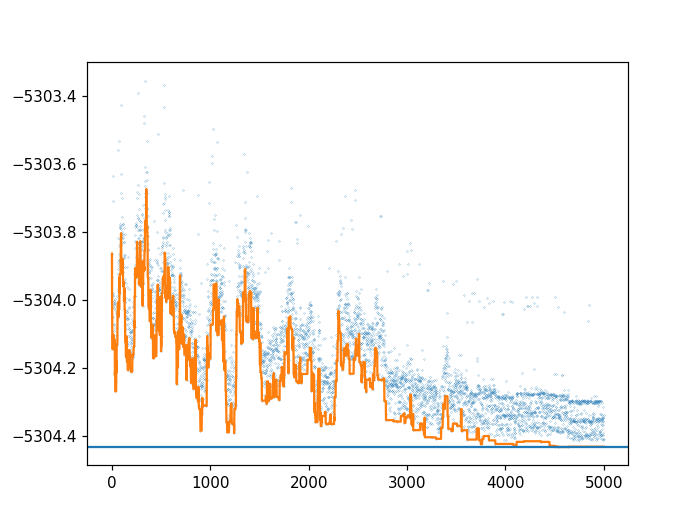

In [179]:
print("Total of {} timesteps with an acceptance ratio of: {}".format(len(energies), float(naccept)/len(energies)))
plt.figure()
plt.plot(e_curr, 'C1')
plt.scatter(np.arange(len(energies)),energies, marker = '.', s = 0.1)
plt.axhline(e_min)

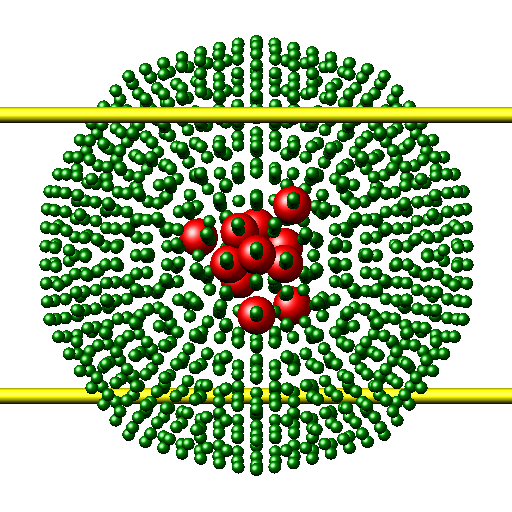

In [181]:
lmp.scatter_atoms("x", 1, 3, pos_old)
lmp.command("write_dump all image snapshot.png type type zoom 3.0 view 60 00 modify backcolor white adiam 1 3.0")
Image('snapshot.png')

### Possibly dump the output geometry to view it in other programs:

In [8]:
lmp.command("write_dump all xyz NiAu_min.xyz modify sort id")